In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import os

2024-02-06 13:46:43.075682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 13:46:43.075784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 13:46:43.246312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


This is a quick notebook that I made to test the Unet in an ideal environment. 

I'm hopeful that I will be able to modify it and use it for more difficult datasets.

# Data visualization

First we retrieve the images and masks and put them in lists.

In [2]:
images = []
masks = []


for dirname, _, filenames in os.walk('/kaggle/input/lyft-udacity-challenge/'):
    for filename in filenames:
        if 'Seg' in dirname:
            masks += [os.path.join(dirname, filename)]
        elif 'RGB' in dirname:
            images += [os.path.join(dirname, filename)]

df_sem = pd.DataFrame(data={'image': images, 'mask': masks})

In [3]:
pd.options.display.max_colwidth = 110
df_sem.head()

,image,mask
0,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/06_00_062.png,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
1,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/08_00_082.png,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
2,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/F9-52.png,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
3,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/02_00_242.png,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
4,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/05_00_183.png,/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png


In [4]:
df_sem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10000 non-null  object
 1   mask    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


We can quickly see the images and their masks.

In [5]:
import cv2

def show_sem(df, start=0, stop=5):
    img_paths = df.iloc[start:stop].values
    for img_path, mask_path in img_paths:
        
        image_sem = cv2.imread(img_path)
        image_sem = cv2.cvtColor(image_sem,cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(mask_path)
        image_mask = cv2.cvtColor(image_mask,cv2.COLOR_BGR2GRAY)
        
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(image_sem[:,:,:]) 
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(image_mask[:,:])  
        plt.axis('off')
        plt.show() 

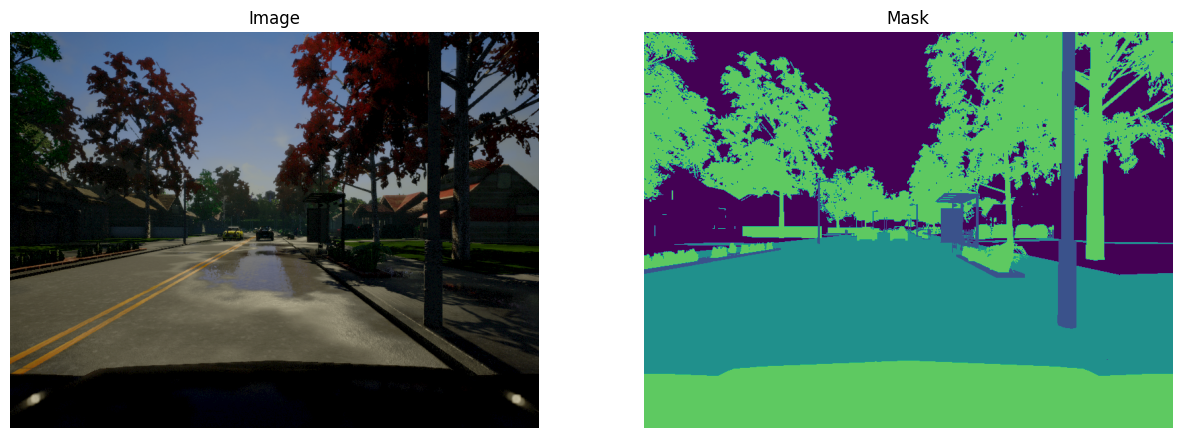

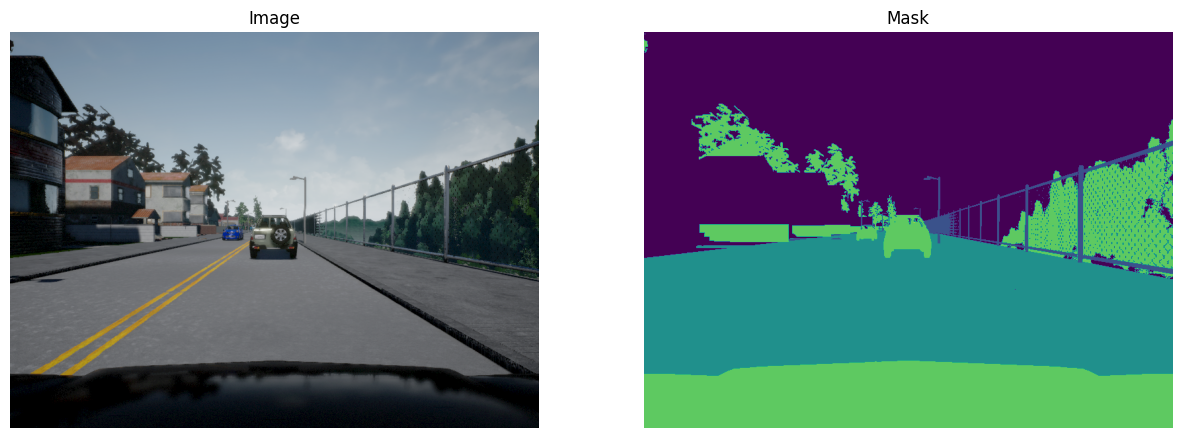

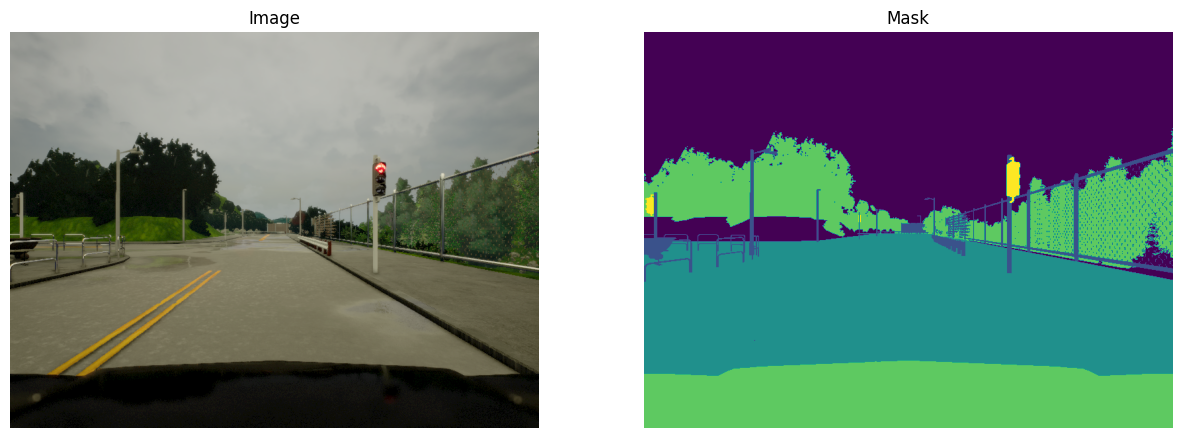

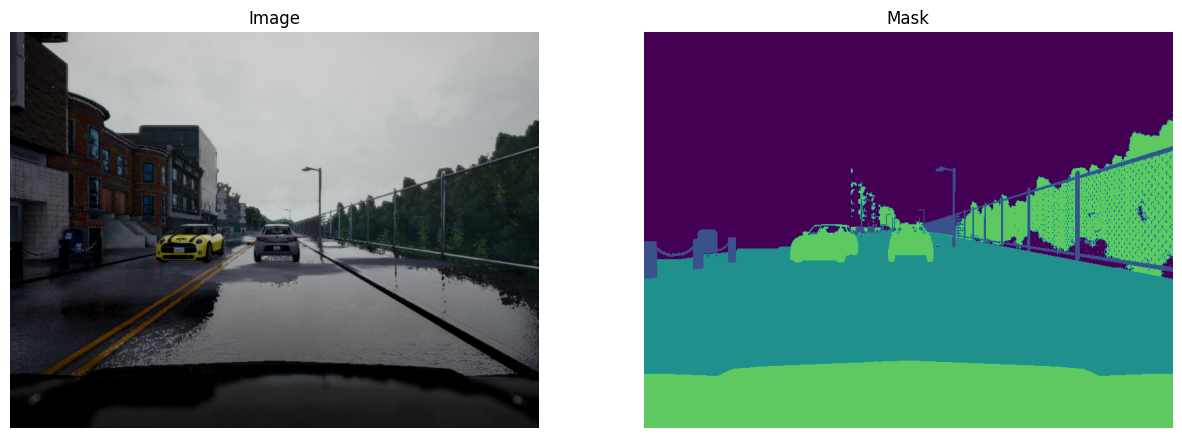

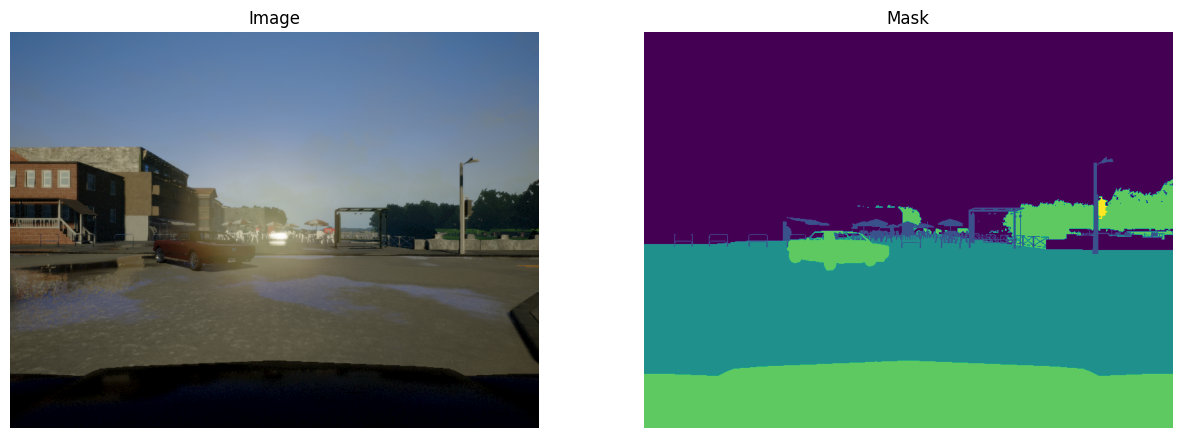

In [6]:
show_sem(df_sem)

# DATA Pipeline

Nowm we are going to build our TF dataset (valid and train, but no test. You can add one yourself if you need to, it's not difficult)

In [7]:
batch_size = 32
img_height = 192
img_width = 256
num_channels = 3

In [8]:
from sklearn.model_selection import train_test_split

train_images, valid_images, train_masks, valid_masks = train_test_split(images, masks, test_size=0.2, random_state=1)

Add the files path into TF datasets.

In [9]:
image_filenames_train = tf.constant(train_images)
masks_filenames_train = tf.constant(train_masks)

train_dataset = tf.data.Dataset.from_tensor_slices((image_filenames_train, masks_filenames_train))

image_filenames_valid = tf.constant(valid_images)
masks_filenames_valid = tf.constant(valid_masks)

valid_dataset = tf.data.Dataset.from_tensor_slices((image_filenames_valid, masks_filenames_valid))

Open the images, process them, and put them in another dataset.

In [10]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #concert [0,255] values to [0,1] directly, no need to normalize

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #Takes the max along the last axis (channels) and keep the last dim ((H,W,3) to (H,W,1))
    return img, mask

def preprocess(image, mask, img_width=img_width, img_height=img_height):
    input_image = tf.image.resize(image, (img_height, img_width), method='nearest')
    input_mask = tf.image.resize(mask, (img_height, img_width), method='nearest')

    return input_image, input_mask

train_image_ds = train_dataset.map(process_path)
train_processed_image_ds = train_image_ds.map(preprocess)

valid_image_ds = valid_dataset.map(process_path)
valid_processed_image_ds = valid_image_ds.map(preprocess)

# Unet model

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)   
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """

    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [13]:
def Unet_model(input_size=(128, 128, 3), n_filters=64, n_classes=13):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, 0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, 0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
unet = Unet_model((img_height, img_width, num_channels))

In [15]:
loss_fc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)



unet.compile(optimizer='adam',
             loss=loss_fc,
             metrics=['accuracy'])

In [16]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 96, 128, 64)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Fitting

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', 
                           restore_best_weights=True, 
                           patience=3)]

In [18]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)
history = unet.fit(train_dataset, 
                   epochs=EPOCHS, 
                   validation_data=valid_dataset,
                   callbacks=callbacks)

(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/40


2024-02-06 13:47:09.054655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707227258.004649      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 514s 2s/step - loss: 0.9307 - accuracy: 0.7128 - val_loss: 0.3455 - val_accuracy: 0.8971
Epoch 2/40
250/250 [==============================] - 427s 2s/step - loss: 0.2419 - accuracy: 0.9248 - val_loss: 0.1779 - val_accuracy: 0.9443
Epoch 3/40
250/250 [==============================] - 429s 2s/step - loss: 0.1512 - accuracy: 0.9517 - val_loss: 0.1354 - val_accuracy: 0.9568
Epoch 4/40
250/250 [==============================] - 429s 2s/step - loss: 0.1130 - accuracy: 0.9633 - val_loss: 0.1045 - val_accuracy: 0.9657
Epoch 5/40
250/250 [==============================] - 429s 2s/step - loss: 0.0950 - accuracy: 0.9686 - val_loss: 0.0852 - val_accuracy: 0.9717
Epoch 6/40
250/250 [==============================] - 429s 2s/step - loss: 0.0793 - accuracy: 0.9733 - val_loss: 0.0745 - val_accuracy: 0.9747
Epoch 7/40
250/250 [==============================] - 429s 2s/step - loss: 0.0682 - accuracy: 0.9766 - val_loss: 0.0652 - val_accuracy: 0.9776
Epoch 8/40

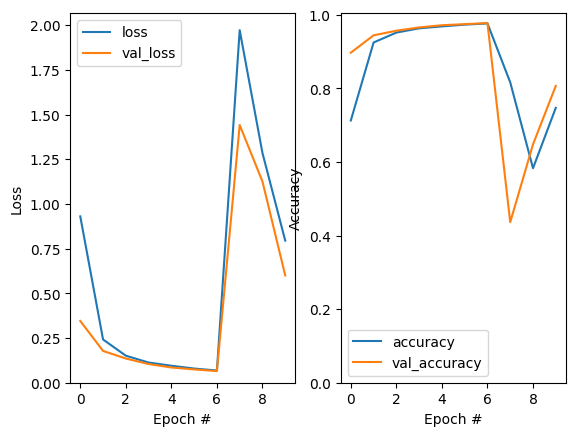

In [19]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

There is a problem in with the masks cmap I think. The same Tag seems to be shown with different colour. Right now I don't know why so I can't correct it (But I can assure you that the values are the same).

1/1 [==============================] - 0s 295ms/step


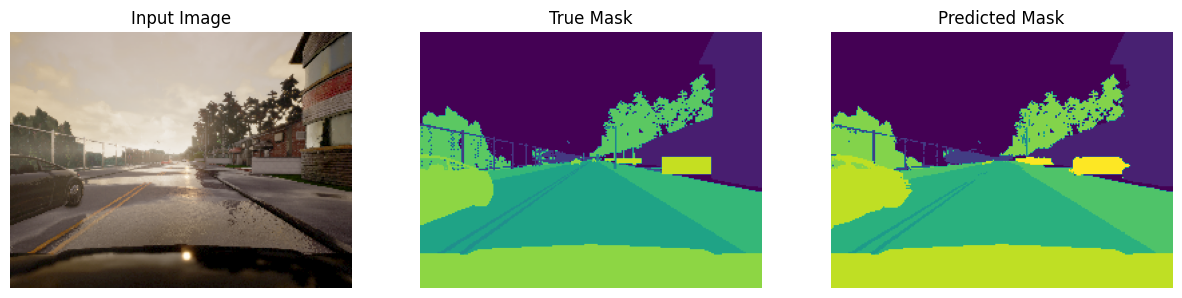

1/1 [==============================] - 0s 27ms/step


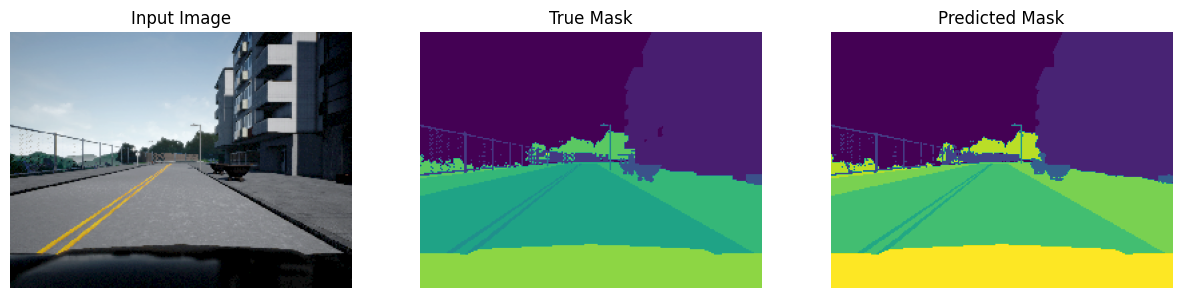

1/1 [==============================] - 0s 48ms/step


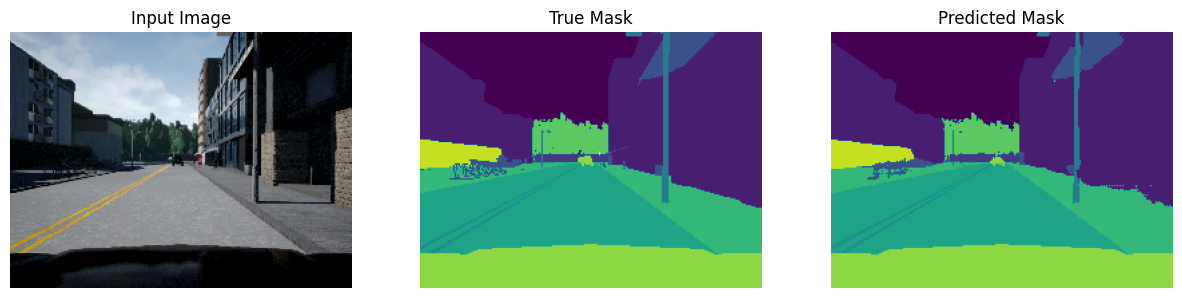

1/1 [==============================] - 0s 27ms/step


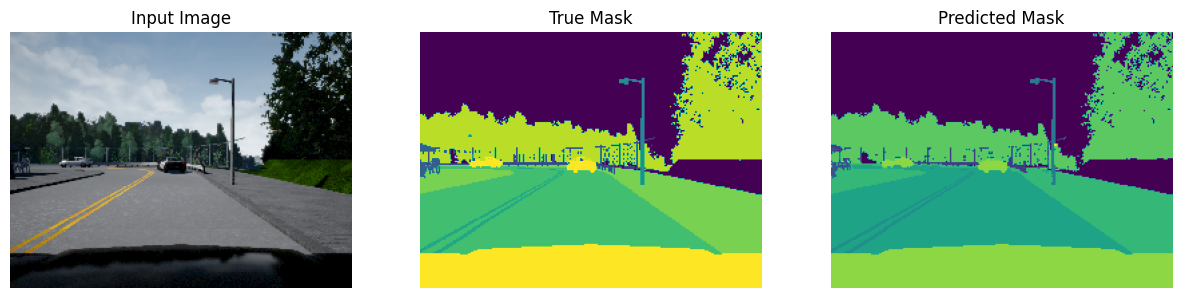

1/1 [==============================] - 0s 27ms/step


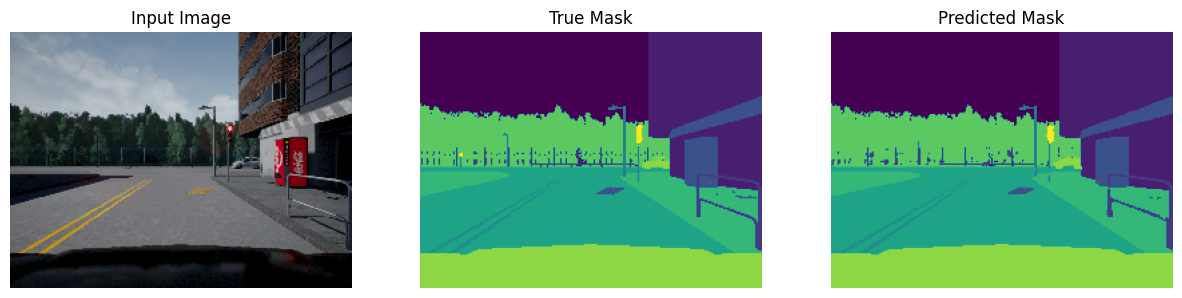

1/1 [==============================] - 0s 27ms/step


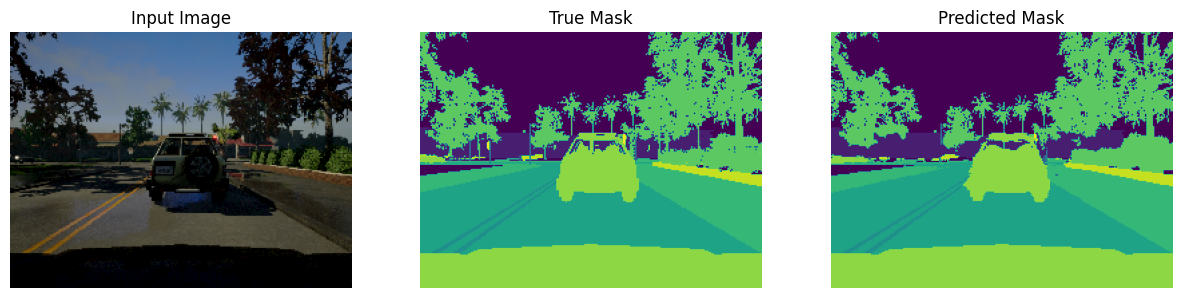

In [23]:
show_predictions(valid_dataset, 6)